<a href="https://colab.research.google.com/github/akobiisr/NLP-TP3/blob/main/TP3NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sklearn-pycrfsuite

In [2]:
import spacy
import numpy as np
import itertools
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.callbacks import  *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn_crfsuite.metrics import flat_classification_report
import matplotlib.pyplot as plt
from random import randint


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
#https://colab.research.google.com/drive/1cMmtzM7rYc-cpW0fkRiTRb-ySr2UHf1h#scrollTo=086fpOA1lWlx

Mounted at /content/gdrive


#Loader les données

Choisir les données à utiliser en fonction du données


In [27]:
"""
data_type peut prendre la valeur de disease ou science
"""
def load_filename(data_type):
  test_filename = " "
  train_filename = " "
  valid_filename = " "

  if data_type == "science":
    test_filename = "/content/gdrive/My Drive/science/test.txt"
    train_filename = "/content/gdrive/My Drive/science/train.txt"
    valid_filename = "/content/gdrive/My Drive/science/dev.txt"

  if data_type == "disease":
    test_filename = "/content/gdrive/My Drive/disease/test.txt"
    train_filename = "/content/gdrive/My Drive/disease/train.txt"
    valid_filename = "/content/gdrive/My Drive/disease/dev.txt"
    
  return train_filename, valid_filename, test_filename

Chargé les données et les séparer en phrases


In [28]:
def load_data(filename):
  data= list()
  labels = list()
  with open(filename) as fn:
    content = fn.readlines()
  #sentence = 0
  sentence = list()
  sent_label = list()
  for x in content:
    x = x.strip().split('\t')
    if len(x) !=1:
      sentence.append(x[0])
      x[1] = x[1].replace('B-', 'I-')
      sent_label.append(x[1].replace('I-', ''))
      #word.append(sentence)
      #data.append(word)
    else:
      sentence = " ".join(sentence)
      data.append(sentence)
      labels.append(sent_label)           
      sentence, sent_label = list(), list()
      
  return data, labels

In [29]:
#Cette fonction enlève les données vides
def withraw_empty_data(data, label):
  for d, l in zip(data, label):
    if len(d.split()) ==0: # Verifie si la phrase est vide est la suprimer de la liste
      data.pop(data.index(d))
      label.pop(label.index(l))
  return data, label

Découper la donnée en phrase (sequence de mots) ainsi que les labels


In [30]:
def words_to_sentence(filename):
  data, sentence = load_data(filename)
  sentence_data = list()
  word_sentence_label = list()
  
  last_visited =0
  
  for sent in range(sentence):
    tmp_data = list()
    tmp_label = list()
    for idx in range(last_visited, len(data)):
      #print(idx)
      if data[idx][2] == sent:
        tmp_data.append(data[idx][0])
        tmp_label.append(data[idx][1])
        last_visited = idx+1
      else:
        #last_visited = idx - 1
        #print(last_visited)
        break
    sentence_data.append(tmp_data)
    word_sentence_label.append(tmp_label)



  return sentence_data, word_sentence_label

In [31]:
train_filename, valid_filename, test_filename = load_filename("disease")

In [32]:
d_train_data, d_train_label = load_data(train_filename)
d_valid_data, d_valid_label = load_data(valid_filename)
d_test_data, d_test_label = load_data(test_filename)

d_train_data, d_train_label = withraw_empty_data(d_train_data, d_train_label)
d_valid_data, d_valid_label = withraw_empty_data(d_valid_data, d_valid_label)
d_test_data, d_test_label = withraw_empty_data(d_test_data, d_test_label)

In [33]:
train_filename, valid_filename, test_filename = load_filename("science")

In [34]:
s_train_data, s_train_label = load_data(train_filename)
s_valid_data, s_valid_label = load_data(valid_filename)
s_test_data, s_test_label = load_data(test_filename)

s_train_data, s_train_label = withraw_empty_data(s_train_data, s_train_label)
s_valid_data, s_valid_label = withraw_empty_data(s_valid_data, s_valid_label)
s_test_data, s_test_label = withraw_empty_data(s_test_data, s_test_label)

#Analyse de donées de disease

In [35]:
print("nombre de phrase dans la données d'entrainement :", len(d_train_data))
print("nombre de phrase dans la données de validation :", len(d_valid_data))
print("nombre de phrase dans la données de test :", len(d_test_data))


nombre de phrase dans la données d'entrainement : 5424
nombre de phrase dans la données de validation : 923
nombre de phrase dans la données de test : 940


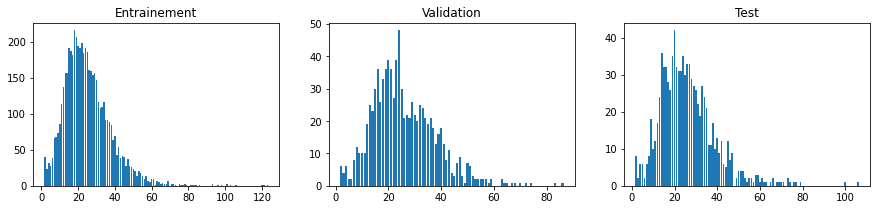

In [36]:
sent_train_len = [len(sent.split()) for sent in d_train_data]
sent_valid_len = [len(sent.split()) for sent in d_valid_data]
sent_test_len = [len(sent.split()) for sent in d_test_data]

sent_train_len, tr_counts = np.unique(np.array(sent_train_len), return_counts=True)
sent_valid_len, val_counts = np.unique(np.array(sent_valid_len), return_counts=True)
sent_test_len, test_counts = np.unique(np.array(sent_test_len), return_counts=True)

plt.figure(figsize=(15, 3))

plt.subplot(131)
plt.bar(sent_train_len, tr_counts)
plt.gca().set_title('Entrainement')

plt.subplot(132)
plt.bar(sent_valid_len, val_counts)
plt.gca().set_title('Validation')

plt.subplot(133)
plt.bar(sent_test_len, test_counts)
plt.gca().set_title('Test')

#plt.suptitle('Longeur des phrases')
plt.show()

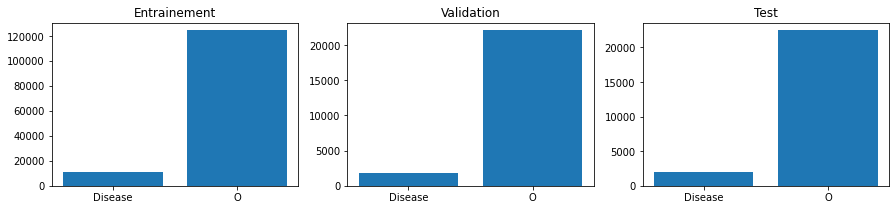

In [37]:
def label_list(labels):
  list_labels = list()
  for label in labels:
    list_labels += label
  unique_labels, counts = np.unique(np.array(list_labels), return_counts=True)
  return unique_labels, counts

sent_train_label, tr_counts = label_list(d_train_label)
sent_valid_label, val_counts = label_list(d_valid_label)
sent_test_label, test_counts = label_list(d_test_label)

plt.figure(figsize=(15, 3))

plt.subplot(131)
plt.bar(sent_train_label, tr_counts)
plt.gca().set_title('Entrainement')


plt.subplot(132)
plt.bar(sent_valid_label, val_counts)
plt.gca().set_title('Validation')

plt.subplot(133)
plt.bar(sent_test_label, test_counts)
plt.gca().set_title('Test')

#plt.suptitle('REPARTITION DES LABELS')
plt.show()

#Analyse de données science

In [38]:
print("nombre de phrase dans la données d'entrainement :", len(s_train_data))
print("nombre de phrase dans la données de validation :", len(s_valid_data))
print("nombre de phrase dans la données de test :", len(s_test_data))


nombre de phrase dans la données d'entrainement : 1861
nombre de phrase dans la données de validation : 275
nombre de phrase dans la données de test : 551


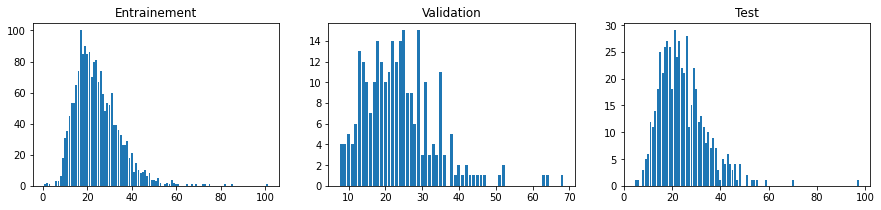

In [39]:
sent_train_len = [len(sent.split()) for sent in s_train_data]
sent_valid_len = [len(sent.split()) for sent in s_valid_data]
sent_test_len = [len(sent.split()) for sent in s_test_data]

sent_train_len, tr_counts = np.unique(np.array(sent_train_len), return_counts=True)
sent_valid_len, val_counts = np.unique(np.array(sent_valid_len), return_counts=True)
sent_test_len, test_counts = np.unique(np.array(sent_test_len), return_counts=True)

plt.figure(figsize=(15, 3))

plt.subplot(131)
plt.bar(sent_train_len, tr_counts)
plt.gca().set_title('Entrainement')

plt.subplot(132)
plt.bar(sent_valid_len, val_counts)
plt.gca().set_title('Validation')

plt.subplot(133)
plt.bar(sent_test_len, test_counts)
plt.gca().set_title('Test')

#plt.suptitle('Longeur des phrases')
plt.show()

Liste des labels:  ['Generic' 'Material' 'Method' 'Metric' 'O' 'OtherScientificTerm' 'Task']


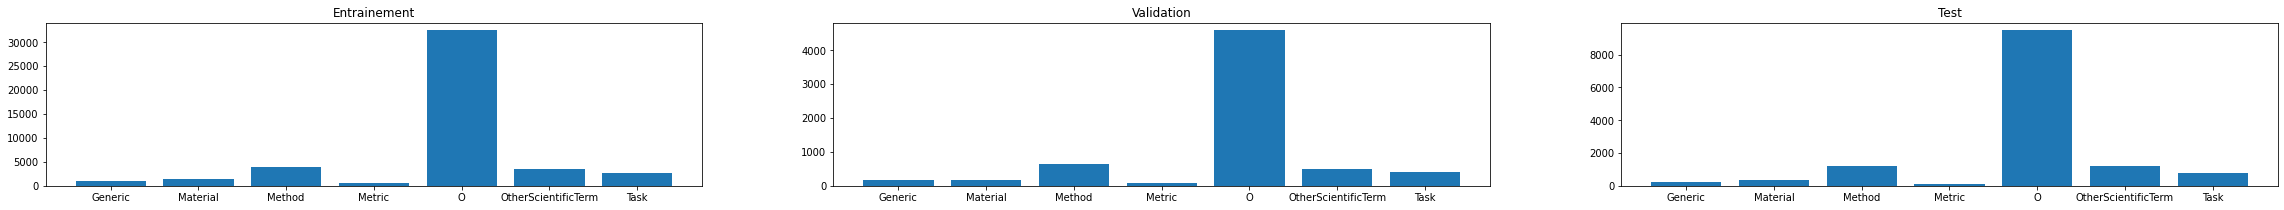

In [40]:
sent_train_label, tr_counts = label_list(s_train_label)
sent_valid_label, val_counts = label_list(s_valid_label)
sent_test_label, test_counts = label_list(s_test_label)

print("Liste des labels: ", sent_train_label)
plt.figure(figsize=(40, 3))

plt.subplot(131)
plt.bar(sent_train_label, tr_counts)
plt.gca().set_title('Entrainement')


plt.subplot(132)
plt.bar(sent_valid_label, val_counts)
plt.gca().set_title('Validation')

plt.subplot(133)
plt.bar(sent_test_label, test_counts)
plt.gca().set_title('Test')

#plt.suptitle('REPARTITION DES LABELS')
plt.show()

#Prétraitement des données science

In [41]:
s_vocab = set(itertools.chain(*[[w for w in s.split()] for s in s_train_data]))
label_unique = set(itertools.chain(*[[w for w in s] for s in s_train_label]))  
S_VOCAB_SIZE = len(s_vocab)
S_LABEL_SIZE = len(label_unique)

In [42]:
print(S_VOCAB_SIZE, S_LABEL_SIZE)

5964 7


In [43]:
S_MAX_LEN = 0
for t in s_train_data:
  if len(t.split())> S_MAX_LEN:
    S_MAX_LEN = len(t.split())
    #print(t)
print(S_MAX_LEN)

101


In [44]:
s_word_tokenizer = Tokenizer(num_words=S_VOCAB_SIZE, oov_token='UNK')
s_word_tokenizer.fit_on_texts(s_train_data)
s_word_index = s_word_tokenizer.word_index
s_word_index['__PADDING__'] = 0
s_index_word = {i:w for w, i in s_word_index.items()}

x_s_train = s_word_tokenizer.texts_to_sequences(s_train_data)
x_s_valid = s_word_tokenizer.texts_to_sequences(s_valid_data)
x_s_test = s_word_tokenizer.texts_to_sequences(s_test_data)

x_s_train = pad_sequences(x_s_train, maxlen=S_MAX_LEN, padding='post')
x_s_valid = pad_sequences(x_s_valid, maxlen=S_MAX_LEN, padding='post')
x_s_test = pad_sequences(x_s_test, maxlen=S_MAX_LEN, padding='post')

In [45]:
print(x_s_train[0])

[ 101    9  164    6   23 2983  119  374   13    2  470    3 2984    3
    2  614  615   11 2985 2115  151  471 1669 1141    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


In [46]:
s_tag_tokenizer = Tokenizer(num_words=S_LABEL_SIZE, lower=False, document_count=0)
s_tag_tokenizer.fit_on_texts(s_train_label)

s_tag_index = s_tag_tokenizer.word_index
s_tag_index['__PADDING__'] = 0
s_index_tag = {i:w for w, i in s_tag_index.items()}

s_index_tag_wo_padding = dict(s_index_tag)
s_index_tag_wo_padding[s_tag_index['__PADDING__']] = 'O'


y_s_train = s_tag_tokenizer.texts_to_sequences(s_train_label)
y_s_valid = s_tag_tokenizer.texts_to_sequences(s_valid_label)
y_s_test = s_tag_tokenizer.texts_to_sequences(s_test_label)

y_s_train = pad_sequences(y_s_train, maxlen=S_MAX_LEN, padding='post')
y_s_valid = pad_sequences(y_s_valid, maxlen=S_MAX_LEN, padding='post')
y_s_test = pad_sequences(y_s_test, maxlen=S_MAX_LEN, padding='post')

In [47]:
print(y_s_train[0])

[5 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 3 3 3 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [48]:
y_s_train = np.expand_dims(y_s_train, -1)
y_s_valid = np.expand_dims(y_s_valid, -1)
y_s_test = np.expand_dims(y_s_test, -1)

In [49]:
x_s_train.shape

(1861, 101)

#Prétraitement des données Disease

In [50]:
d_vocab = set(itertools.chain(*[[w for w in s.split()] for s in d_train_data]))
label_unique = set(itertools.chain(*[[w for w in s] for s in d_train_label]))  
D_VOCAB_SIZE = len(s_vocab)
D_LABEL_SIZE = len(label_unique)

In [51]:
print(D_VOCAB_SIZE, D_LABEL_SIZE)

5964 2


In [52]:
D_MAX_LEN = 0
for t in d_train_data:
  if len(t.split())> D_MAX_LEN:
    D_MAX_LEN = len(t.split())
print(D_MAX_LEN)

123


In [53]:
d_word_tokenizer = Tokenizer(num_words=D_VOCAB_SIZE, oov_token='UNK')
d_word_tokenizer.fit_on_texts(d_train_data)
d_word_index = d_word_tokenizer.word_index
d_word_index['__PADDING__'] = 0
d_index_word = {i:w for w, i in d_word_index.items()}

x_d_train = d_word_tokenizer.texts_to_sequences(d_train_data)
x_d_valid = d_word_tokenizer.texts_to_sequences(d_valid_data)
x_d_test = d_word_tokenizer.texts_to_sequences(d_test_data)

x_d_train = pad_sequences(x_d_train, maxlen=D_MAX_LEN, padding='post')
x_d_valid = pad_sequences(x_d_valid, maxlen=D_MAX_LEN, padding='post')
x_d_test = pad_sequences(x_d_test, maxlen=D_MAX_LEN, padding='post')

In [54]:
print(x_d_train[0])

[ 218    3 2297    6  620    3    2  307  256  484  683  517    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


In [55]:
d_tag_tokenizer = Tokenizer(num_words=D_LABEL_SIZE, lower=False, document_count=0)
d_tag_tokenizer.fit_on_texts(d_train_label)

d_tag_index = d_tag_tokenizer.word_index
d_tag_index['__PADDING__'] = 0
d_index_tag = {i:w for w, i in d_tag_index.items()}

d_index_tag_wo_padding = dict(d_index_tag)
d_index_tag_wo_padding[d_tag_index['__PADDING__']] = 'O'


y_d_train = d_tag_tokenizer.texts_to_sequences(d_train_label)
y_d_valid = d_tag_tokenizer.texts_to_sequences(d_valid_label)
y_d_test = d_tag_tokenizer.texts_to_sequences(d_test_label)

y_d_train = pad_sequences(y_d_train, maxlen=D_MAX_LEN, padding='post')
y_d_valid = pad_sequences(y_d_valid, maxlen=D_MAX_LEN, padding='post')
y_d_test = pad_sequences(y_d_test, maxlen=D_MAX_LEN, padding='post')

In [56]:
print(y_d_train[0])

[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


In [57]:
y_d_train = np.expand_dims(y_d_train, -1)
y_d_valid = np.expand_dims(y_d_valid, -1)
y_d_test = np.expand_dims(y_d_test, -1)

# Modèle

In [58]:
embeddings_index = dict()
f = open('/content/gdrive/My Drive/glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [1]:
# Cette fonction crée le modèle à utiliser
def get_model(vocab, label_size, max_len, embeddings = None):
  model = Sequential()
  if embeddings:
    #charger l'embedding des mots
    num_words = len(vocab)
    embedding_matrix = np.zeros((num_words, 300))

    for word, i in zip(vocab, range(len(vocab))):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    model.add(Embedding(len(vocab),300,input_length=max_len,trainable=False))
    model.add(Bidirectional(LSTM(512,return_sequences=True,dropout=0.2))) 
    model.add(TimeDistributed(Dense(label_size+1, activation='softmax')))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=["acc"])

  else:
    model.add(Embedding(len(vocab),300,input_length=max_len,trainable=True)) # Couche d'embedding
    model.add(Bidirectional(LSTM(512,return_sequences=True,dropout=0.2))) # Couche de Bidirectionel LSTM
    
    model.add(TimeDistributed(Dense(label_size+1, activation='softmax'))) # Couche de classification de sequence
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=["acc"])
    

  return model


In [60]:
EPOCHS = 5

#Model with science data

In [83]:
model = get_model(s_vocab,S_LABEL_SIZE, S_MAX_LEN)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 101, 300)          1789200   
_________________________________________________________________
bidirectional (Bidirectional (None, 101, 1024)         3330048   
_________________________________________________________________
time_distributed (TimeDistri (None, 101, 8)            8200      
Total params: 5,127,448
Trainable params: 5,127,448
Non-trainable params: 0
_________________________________________________________________
None


In [84]:
history = model.fit(x_s_train, np.array(y_s_train), epochs=EPOCHS, validation_data=(x_s_valid, np.array(y_s_valid)))

Epoch 1/5
59/59 [==============================] - 199s 3s/step - loss: 0.6477 - acc: 0.8333 - val_loss: 0.2728 - val_acc: 0.9227
Epoch 2/5
59/59 [==============================] - 193s 3s/step - loss: 0.2610 - acc: 0.9247 - val_loss: 0.2458 - val_acc: 0.9226
Epoch 3/5
59/59 [==============================] - 194s 3s/step - loss: 0.2239 - acc: 0.9269 - val_loss: 0.2283 - val_acc: 0.9268
Epoch 4/5
59/59 [==============================] - 192s 3s/step - loss: 0.1956 - acc: 0.9337 - val_loss: 0.2217 - val_acc: 0.9284
Epoch 5/5
59/59 [==============================] - 191s 3s/step - loss: 0.1653 - acc: 0.9441 - val_loss: 0.2197 - val_acc: 0.9292


In [66]:
def plotTraining(epochs, history):
  plt.plot(range(EPOCHS), history.history['loss'], label = "train loss")
  plt.plot(range(EPOCHS), history.history['val_loss'], label = "valid loss")
  plt.legend()
  plt.title("Training loss")
  plt.show()

  plt.plot(range(EPOCHS), history.history['acc'], label = "train acc")
  plt.plot(range(EPOCHS), history.history['val_acc'], label = "valid acc")
  plt.legend()
  plt.title("Training acc")
  plt.show()

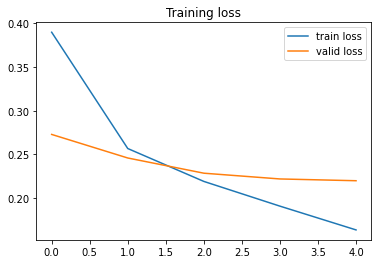

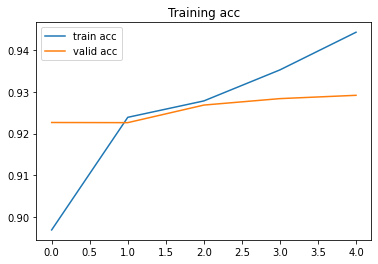

In [86]:
plotTraining(EPOCHS, history)

In [96]:
predicted = model.predict(x_s_test)
predicted_tags = []
for s, s_pred in zip(s_test_data, predicted):
    tags = np.argmax(s_pred, axis=1)
    tags = tags[:len(s.split())]
    labels = [s_index_tag_wo_padding[tag] for tag in tags]
    #print(labels)
    predicted_tags.append(labels)

In [103]:
test_i = randint(0,len(s_test_data))
sent = s_test_data[test_i].split()
for i in range(len(sent)):
  print(predicted_tags[test_i][i]," -------", s_test_label[test_i][i])

O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
Method  ------- Task
Task  ------- Task
O  ------- Task
O  ------- Task
O  ------- Task
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- Task
OtherScientificTerm  ------- Task
OtherScientificTerm  ------- Task
OtherScientificTerm  ------- O
O  ------- O
O  ------- O
O  ------- OtherScientificTerm
O  ------- OtherScientificTerm
O  ------- OtherScientificTerm
O  ------- OtherScientificTerm
O  ------- O


In [100]:
print(flat_classification_report(s_test_label, predicted_tags))

                     precision    recall  f1-score   support

            Generic       0.64      0.18      0.28       257
           Material       0.63      0.06      0.12       375
             Method       0.60      0.34      0.43      1177
             Metric       0.00      0.00      0.00       140
                  O       0.77      0.96      0.85      9467
OtherScientificTerm       0.46      0.13      0.21      1218
               Task       0.46      0.30      0.36       767

           accuracy                           0.74     13401
          macro avg       0.51      0.28      0.32     13401
       weighted avg       0.69      0.74      0.69     13401



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
model = get_model(s_vocab,S_LABEL_SIZE, S_MAX_LEN, embeddings_index)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 101, 300)          1789200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 101, 1024)         3330048   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 101, 8)            8200      
Total params: 5,127,448
Trainable params: 3,338,248
Non-trainable params: 1,789,200
_________________________________________________________________
None


In [106]:
history = model.fit(x_s_train, np.array(y_s_train), epochs=EPOCHS, validation_data=(x_s_valid, np.array(y_s_valid)))

Epoch 1/5
59/59 [==============================] - 158s 3s/step - loss: 0.6605 - acc: 0.8054 - val_loss: 0.2772 - val_acc: 0.9217
Epoch 2/5
59/59 [==============================] - 155s 3s/step - loss: 0.2702 - acc: 0.9240 - val_loss: 0.2691 - val_acc: 0.9227
Epoch 3/5
59/59 [==============================] - 160s 3s/step - loss: 0.2704 - acc: 0.9217 - val_loss: 0.2676 - val_acc: 0.9228
Epoch 4/5
59/59 [==============================] - 158s 3s/step - loss: 0.2633 - acc: 0.9228 - val_loss: 0.2623 - val_acc: 0.9226
Epoch 5/5
59/59 [==============================] - 157s 3s/step - loss: 0.2512 - acc: 0.9248 - val_loss: 0.2566 - val_acc: 0.9221


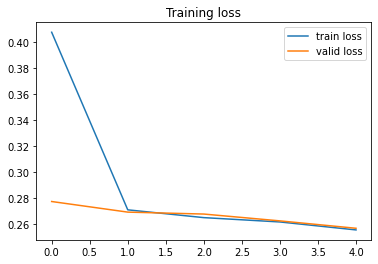

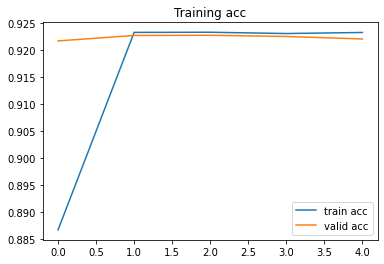

In [107]:
plotTraining(EPOCHS, history)

In [108]:
predicted = model.predict(x_s_test)
predicted_tags = []
for s, s_pred in zip(s_test_data, predicted):
    tags = np.argmax(s_pred, axis=1)
    tags = tags[:len(s.split())]
    labels = [s_index_tag_wo_padding[tag] for tag in tags]
    #print(labels)
    predicted_tags.append(labels)

In [127]:
test_i = randint(0,len(s_test_data))
sent = s_test_data[test_i].split()
for i in range(len(sent)):
  print(predicted_tags[test_i][i]," -------", s_test_label[test_i][i])

O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- Generic
O  ------- O
O  ------- O
O  ------- O
O  ------- O


In [112]:
print(flat_classification_report(s_test_label, predicted_tags))

                     precision    recall  f1-score   support

            Generic       0.00      0.00      0.00       257
           Material       0.00      0.00      0.00       375
             Method       0.40      0.00      0.00      1177
             Metric       0.00      0.00      0.00       140
                  O       0.71      1.00      0.83      9467
OtherScientificTerm       0.00      0.00      0.00      1218
               Task       0.00      0.00      0.00       767

           accuracy                           0.71     13401
          macro avg       0.16      0.14      0.12     13401
       weighted avg       0.53      0.71      0.59     13401



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Model with disease data

In [41]:
model = get_model(d_vocab,D_LABEL_SIZE, D_MAX_LEN)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 123, 300)          2785200   
_________________________________________________________________
bidirectional (Bidirectional (None, 123, 1024)         3330048   
_________________________________________________________________
time_distributed (TimeDistri (None, 123, 3)            3075      
Total params: 6,118,323
Trainable params: 6,118,323
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
history = model.fit(x_d_train, np.array(y_d_train), epochs=EPOCHS, validation_data=(x_d_valid, np.array(y_d_valid)))

Epoch 1/5
170/170 [==============================] - 716s 4s/step - loss: 0.1758 - acc: 0.9293 - val_loss: 0.0438 - val_acc: 0.9840
Epoch 2/5
170/170 [==============================] - 725s 4s/step - loss: 0.0416 - acc: 0.9842 - val_loss: 0.0349 - val_acc: 0.9857
Epoch 3/5
170/170 [==============================] - 716s 4s/step - loss: 0.0290 - acc: 0.9881 - val_loss: 0.0346 - val_acc: 0.9861
Epoch 4/5
170/170 [==============================] - 702s 4s/step - loss: 0.0234 - acc: 0.9903 - val_loss: 0.0385 - val_acc: 0.9854
Epoch 5/5
170/170 [==============================] - 701s 4s/step - loss: 0.0205 - acc: 0.9914 - val_loss: 0.0420 - val_acc: 0.9849


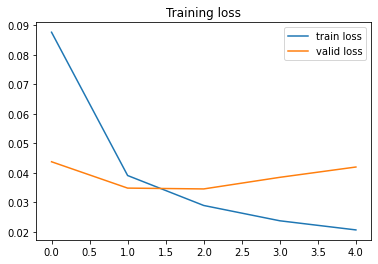

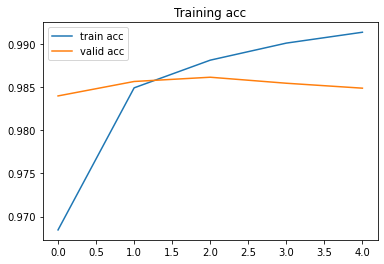

In [43]:
plotTraining(EPOCHS, history)

In [44]:
predicted = model.predict(x_d_test)
predicted_tags = []
for s, s_pred in zip(d_test_data, predicted):
    tags = np.argmax(s_pred, axis=1)
    tags = tags[:len(s.split())]
    labels = [d_index_tag_wo_padding[tag] for tag in tags]
    #print(labels)
    predicted_tags.append(labels)

In [45]:
test_i = randint(0,len(d_test_data))
for i in range(len(d_test_data[test_i].split())):
  print(predicted_tags[test_i][i]," -------", d_test_label[test_i][i])

O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O


In [46]:
print(flat_classification_report(d_test_label, predicted_tags))

              precision    recall  f1-score   support

     Disease       0.00      0.00      0.00      2047
           O       0.92      1.00      0.96     22450

    accuracy                           0.92     24497
   macro avg       0.46      0.50      0.48     24497
weighted avg       0.84      0.92      0.88     24497



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
model = get_model(d_vocab,D_LABEL_SIZE, D_MAX_LEN, embeddings_index)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 123, 300)          2785200   
_________________________________________________________________
bidirectional (Bidirectional (None, 123, 1024)         3330048   
_________________________________________________________________
time_distributed (TimeDistri (None, 123, 3)            3075      
Total params: 6,118,323
Trainable params: 3,333,123
Non-trainable params: 2,785,200
_________________________________________________________________
None


In [64]:
history = model.fit(x_d_train, np.array(y_d_train), epochs=EPOCHS, validation_data=(x_d_valid, np.array(y_d_valid)))

Epoch 1/5
170/170 [==============================] - 587s 3s/step - loss: 0.0483 - acc: 0.9812 - val_loss: 0.0449 - val_acc: 0.9826
Epoch 2/5
170/170 [==============================] - 595s 4s/step - loss: 0.0478 - acc: 0.9813 - val_loss: 0.0459 - val_acc: 0.9821
Epoch 3/5
170/170 [==============================] - 595s 3s/step - loss: 0.0466 - acc: 0.9816 - val_loss: 0.0410 - val_acc: 0.9831
Epoch 4/5
170/170 [==============================] - 593s 3s/step - loss: 0.0450 - acc: 0.9820 - val_loss: 0.0407 - val_acc: 0.9832
Epoch 5/5
170/170 [==============================] - 594s 3s/step - loss: 0.0437 - acc: 0.9824 - val_loss: 0.0409 - val_acc: 0.9833


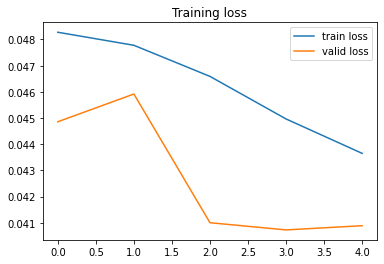

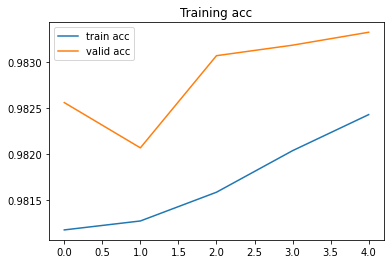

In [67]:
plotTraining(EPOCHS, history)

In [68]:
predicted = model.predict(x_d_test)
predicted_tags = []
for s, s_pred in zip(d_test_data, predicted):
    tags = np.argmax(s_pred, axis=1)
    tags = tags[:len(s.split())]
    labels = [d_index_tag_wo_padding[tag] for tag in tags]
    #print(labels)
    predicted_tags.append(labels)

In [69]:
print(flat_classification_report(d_test_label, predicted_tags))

              precision    recall  f1-score   support

     Disease       0.00      0.00      0.00      2047
           O       0.92      1.00      0.96     22450

    accuracy                           0.92     24497
   macro avg       0.46      0.50      0.48     24497
weighted avg       0.84      0.92      0.88     24497



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
test_i = randint(0,len(d_test_data))
for i in range(len(d_test_data[test_i].split())):
  print(predicted_tags[test_i][i]," -------", d_test_label[test_i][i])

O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- Disease
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
O  ------- O
